In [2]:
#%matplotlib inline
import ROOT
ROOT.gSystem.Load("/home/dhruv/RooUnfold/libRooUnfold")
from ROOT import gRandom, TH1, TH1D, cout
#for unfolding
from ROOT import RooUnfoldResponse
from ROOT import RooUnfold
from ROOT import RooUnfoldBayes
from ROOT import RooUnfoldSvd
from ROOT import RooUnfoldTUnfold
#plotting, style
from matplotlib import pyplot as plt
ROOT.gStyle.SetOptStat('')
from AtlasCommonUtils import SetAtlasStyle
from Legend import Legend
from ROOT import TLatex
SetAtlasStyle()
ROOT.gStyle.SetPalette(ROOT.kViridis);


### Get Data and MC files

In [3]:
Datafile = ROOT.TFile('/home/dhruv/fout_16_13b_pass4_v2_3run_pPb_allevents_forTrackEff_15GeV.root')
#MCfile = ROOT.TFile('/home/dhruv/TrackEfficiency_1GeV16GeV_all.root')
MCfile = ROOT.TFile('/home/dhruv/TrackEfficiency_pPb_1GeV16GeV_2M.root')
#MCfile = ROOT.TFile('/home/dhruv/TrackEfficiency_1GeVpublishBinnig_all.root')
#MCfile = ROOT.TFile('/home/dhruv/TrackEfficiency_20GeV_start1GeV_all.root')
filedata = ROOT.TFile('/home/dhruv/HEPData_20GeV.root','READ')
published_data = filedata.Get('hTrack_HEP')

### Get response Matrix and plot it, also true/reco ratio

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file Matrix_tracking.png has been created


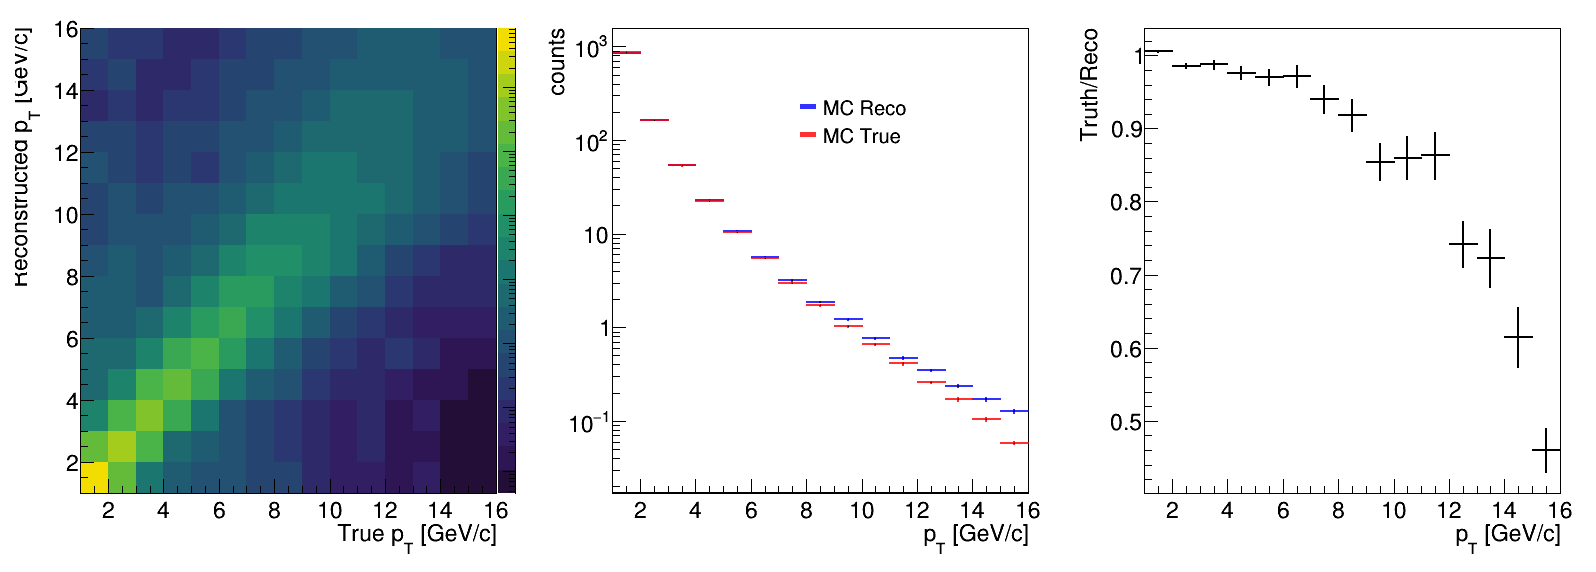

In [4]:
responseMatrix = MCfile.Get("hCorrelation");

#responseMatrix.Rebin2D(2,2)
responseMatrix.ClearUnderflowAndOverflow()
mc_truth = responseMatrix.ProjectionX()
mc_reco = responseMatrix.ProjectionY()
for i in range(mc_truth.GetNbinsX()):
    binWidth = mc_truth.GetBinWidth(i)
    binCon_truth = mc_truth.GetBinContent(i)
    binCon_reco = mc_reco.GetBinContent(i)
    mc_truth.SetBinContent(i, binCon_truth/binWidth)
    mc_reco.SetBinContent(i, binCon_reco/binWidth)
mc_truth.Sumw2()
mc_reco.Sumw2()
mc_truth.SetLineColorAlpha(2,0.8)
mc_reco.SetLineColorAlpha(4,0.8)

##draw mc truth, mc reco, response matrix
c = ROOT.TCanvas('c','c',1600,600)
c.Divide(3)
c.cd(1)
responseMatrix.Draw('colz')
ROOT.gPad.SetLogz()
c.cd(2)

label = Legend("")
label.Add(mc_reco,'MC Reco','L')
label.Add(mc_truth,'MC True','L')

hs_mc = ROOT.THStack()
hs_mc.Add(mc_reco)
hs_mc.Add(mc_truth)
hs_mc.Draw('nostack')
hs_mc.SetTitle('; p_{T} [GeV/c]; counts')

label.Draw(0.5,.87)
ROOT.gPad.SetLogy()
c.cd(3)
ratio_mc = mc_truth.Clone()
ratio_mc.SetLineColor(1)
ratio_mc.Divide(mc_reco)
ratio_mc.Draw('L')
ratio_mc.SetTitle(' ; p_{T} [GeV/c]; Truth/Reco')
c.Draw()
c.SaveAs('Matrix_tracking.png')

### Get measured track pt spectrum

Info in <TCanvas::Print>: png file dataSpectrum_tracking.png has been created


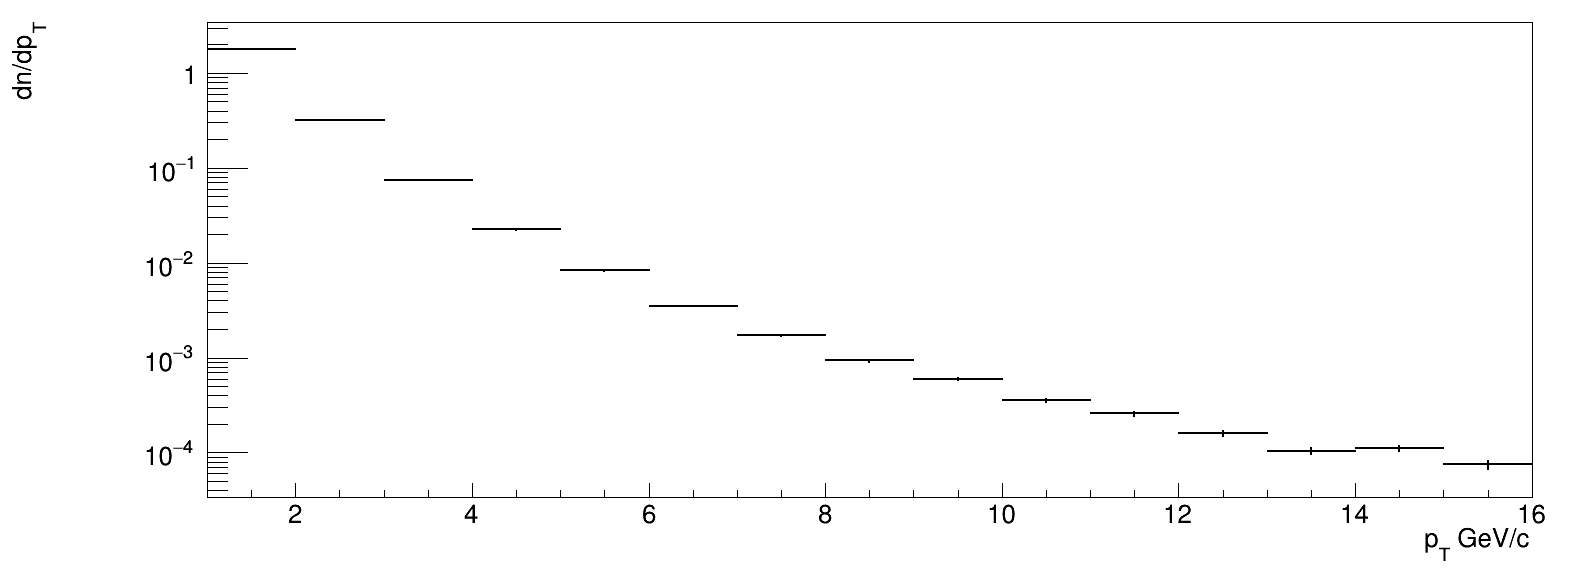

In [5]:
data = Datafile.Get('track_pt')
data.ClearUnderflowAndOverflow()

c.Clear()
data.Draw()
ROOT.gPad.SetLogy()
c.Draw()
c.SaveAs('dataSpectrum_tracking.png')

### Get and plot efficiency and fake rate

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file EfficiencyAndFakeRate_tracking.png has been created


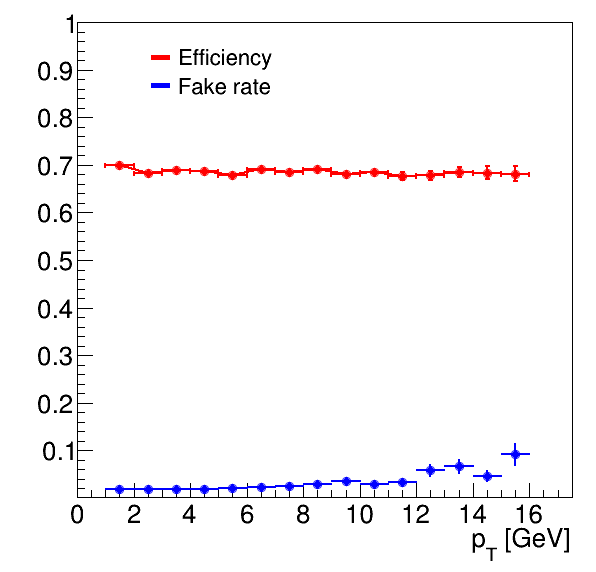

In [6]:
#Get efficiency and fake rate
efficiency = MCfile.Get("Efficiency");
fakerate   = MCfile.Get("FakeRate");

#Plot efficiency and fake rate
efficiency.SetTitle(' ; p_{T} [GeV]')
efficiency.SetMinimum(0.0)
efficiency.SetMaximum(1.0)
efficiency.SetMarkerStyle(20)
efficiency.SetMarkerColor(2)
efficiency.SetLineColor(2)
fakerate.SetMarkerStyle(20)
fakerate.SetLineColor(4)
fakerate.SetMarkerColor(4)

c = ROOT.TCanvas('c','c',600,600)
efficiency.Draw()
fakerate.Draw('same')

label = Legend("")
label.Add(efficiency,'Efficiency','L')
label.Add(fakerate,'Fake rate','L')
label.Draw(.25,.95)
c.Draw()
c.SaveAs('EfficiencyAndFakeRate_tracking.png')

Info in <TCanvas::Print>: png file FakeRake_sub_tracking.png has been created


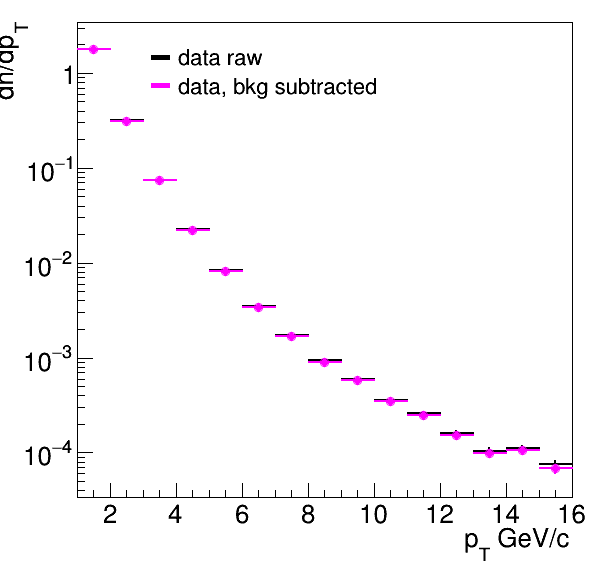

In [7]:
data_bkgsub = data.Clone()
for i in range(1,fakerate.GetNbinsX()+1):
    bkg = data.GetBinContent(i)*fakerate.GetBinContent(i)
    data_bkgsub.SetBinContent(i,data.GetBinContent(i)-bkg)

c.Clear()
data.Draw()
data_bkgsub.SetLineColor(ROOT.kMagenta)
data_bkgsub.SetMarkerColor(ROOT.kMagenta)
data_bkgsub.SetMarkerStyle(20)

data_bkgsub.Draw('same')
ROOT.gPad.SetLogy()
label = Legend("")
label.Add(data,'data raw','L')
label.Add(data_bkgsub,'data, bkg subtracted','L')
label.Draw(.25,.95)
c.Draw()
c.SaveAs('FakeRake_sub_tracking.png')


### DEFINE DATA FOR UNFOLDING 

In [8]:
data_inputforunfolding = data_bkgsub.Clone()
#data_inputforunfolding = data.Clone()

### UNFOLDING 

In [9]:
response= RooUnfoldResponse(mc_reco, mc_truth, responseMatrix)
response.UseOverflow(ROOT.kFALSE)
data_unfolded = {}
#for tau in range(4,6):
#    data_unfolded['SVD%i'%tau] = RooUnfoldSvd(response, data_inputforunfolding, tau).Hreco();
   
data_unfolded['SVD8'] = RooUnfoldSvd(response, data_inputforunfolding, 4).Hreco();
data_unfolded['SVD9'] = RooUnfoldSvd(response, data_inputforunfolding, 5).Hreco();

print data_unfolded

{'SVD9': <ROOT.TH1D object ("hCorrelation") at 0x672d290>, 'SVD8': <ROOT.TH1D object ("hCorrelation") at 0x676ca00>}
SVD init 15 x 15 bins, kreg=4
SVD init 15 x 15 bins, kreg=5


Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 4
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000000
Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 5
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000000


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file Unfoldedresult_tracking.png has been created


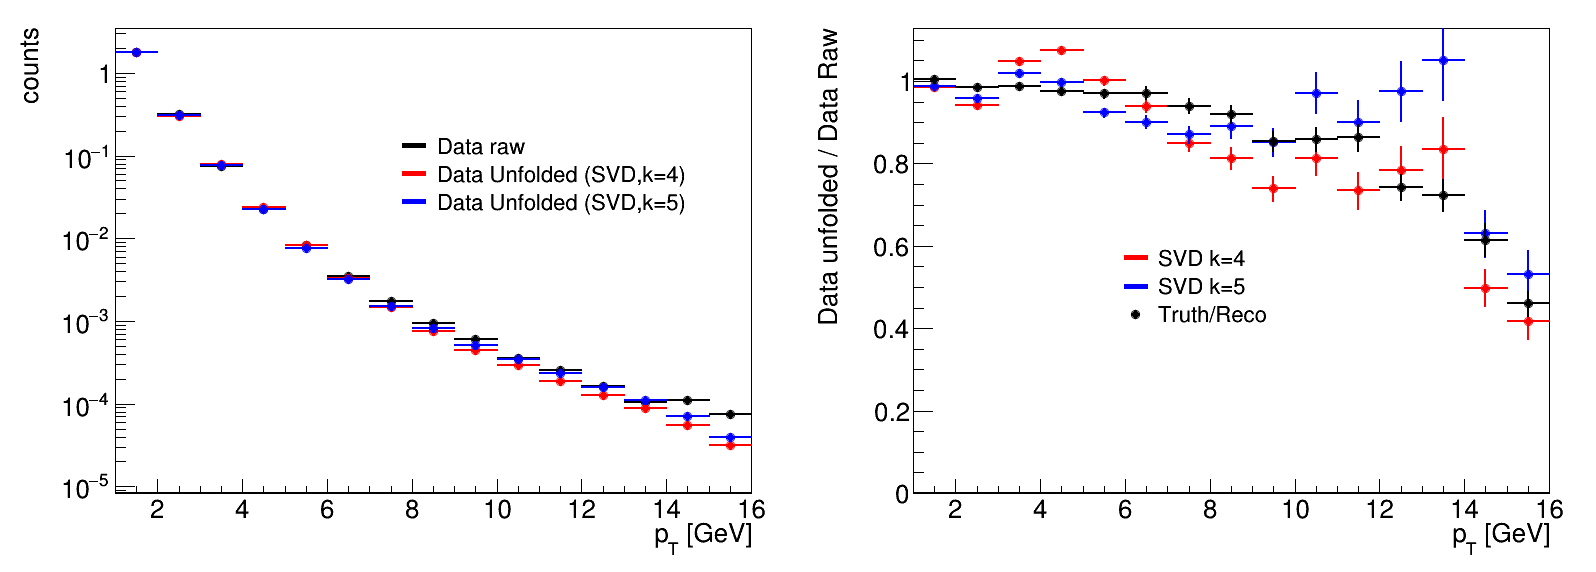

In [10]:
c = ROOT.TCanvas('c','c',1600,600)
c.Divide(2)
c.cd(1)
label = Legend("")

hstack = ROOT.THStack()
hstack.Add(data)
label.Add(data,'Data raw','L')

data.SetMarkerStyle(20)
data_unfolded['SVD8'].SetLineColor(2)
data_unfolded['SVD8'].SetMarkerColor(2)
data_unfolded['SVD8'].SetMarkerStyle(20)
data_unfolded['SVD9'].SetLineColor(4)
data_unfolded['SVD9'].SetMarkerColor(4)
data_unfolded['SVD9'].SetMarkerStyle(20)

hstack.Add(data_unfolded['SVD8'])
hstack.Add(data_unfolded['SVD9'])
label.Add(data_unfolded['SVD8'], 'Data Unfolded (SVD,k=4)','L')
label.Add(data_unfolded['SVD9'], 'Data Unfolded (SVD,k=5)','L')
               
hstack.SetTitle('; p_{T} [GeV]; counts')
hstack.Draw('nostack')
ROOT.gPad.SetLogy()
label.Draw(.5,.8)
c.cd(2)

hs_ratio = ROOT.THStack()
label = Legend("")

ratio = {}
ratio['SVD8'] = data_unfolded['SVD8'].Clone()
ratio['SVD8'].Divide(data) 
ratio['SVD9'] = data_unfolded['SVD9'].Clone()
ratio['SVD9'].Divide(data) 

hs_ratio.Add( ratio['SVD8'])
hs_ratio.Add( ratio['SVD9'])

label.Add(ratio['SVD8'],'SVD k=4','L')
label.Add(ratio['SVD9'],'SVD k=5','L')

#simple bin-by-bin unfolding
ratio_mc.SetMarkerStyle(20)
ratio_mc.SetMarkerSize(1)
ratio_mc.SetMarkerColor(1)

hs_ratio.Add(ratio_mc)

hs_ratio.SetTitle('; p_{T} [GeV]; Data unfolded / Data Raw')
hs_ratio.Draw('nostack')
label.Add(ratio_mc, 'Truth/Reco','P')
label.Draw(.4,.6)
c.Draw()
c.SaveAs('Unfoldedresult_tracking.png')

#Correcting for efficiency


In [11]:
##EFFICIENCY CORRECTION

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file UnfoldedSpectraAndPublishedResult_tracking.png has been created


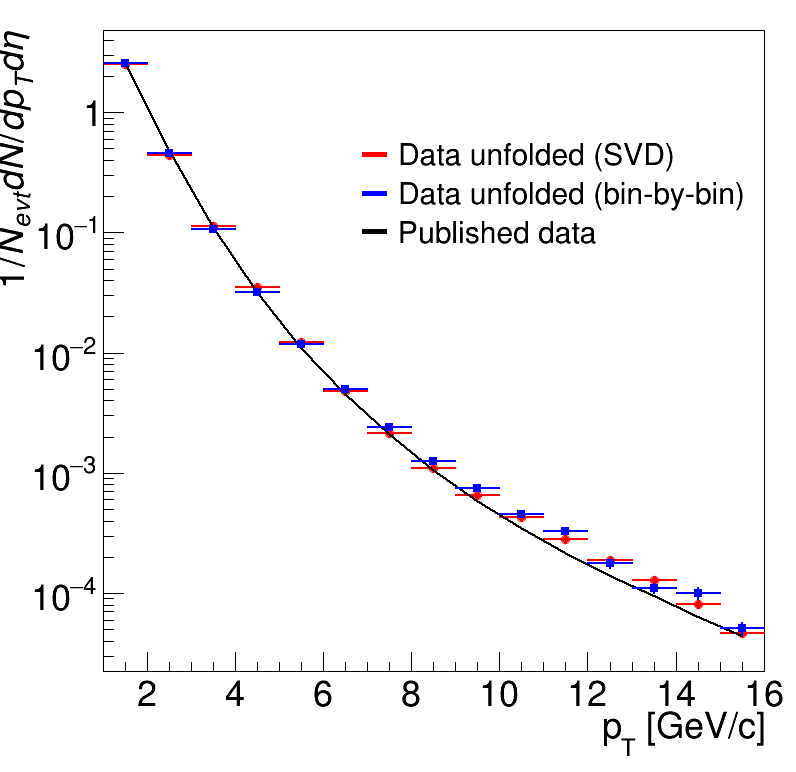

In [12]:
#efficiency.Print()
#applying efficiency
def applyEfficiencyCorrection(histo):
    histo_corrected = histo.Clone()
    for i in range(1,histo.GetNbinsX()+1):
        pt = ROOT.Double()
        eff = ROOT.Double()
        efficiency.GetPoint(i-1,pt,eff)
        #print pt, eff
        histo_corrected.SetBinContent(i,histo.GetBinContent(i)/eff)
        histo_corrected.SetBinError(i,histo.GetBinError(i)/eff)
    return histo_corrected


data_unfolded_SVD_4_corrected = applyEfficiencyCorrection(data_unfolded['SVD8'])
data_unfolded_SVD_5_corrected = applyEfficiencyCorrection(data_unfolded['SVD9'])

data_corrected = data.Clone()
data_onlyeff   = data.Clone()

data_corrected.Multiply(ratio_mc) #applying "naive unfolding"
data_onlyeff = applyEfficiencyCorrection(data_onlyeff)


data_corrected= applyEfficiencyCorrection(data_corrected)
c= ROOT.TCanvas('c','c',800,800)
#c.Divide(2)
#c.cd(1)
data_unfolded_SVD_4_corrected.SetTitle('; p_{T} [GeV/c]; 1/N_{evt} dN/dp_{T}d\eta')
data_unfolded_SVD_4_corrected.SetMarkerStyle(20)
data_unfolded_SVD_4_corrected.SetMarkerColor(2)
#data_unfolded_SVD_4_corrected.GetXaxis().SetRangeUser(1,12)
data_unfolded_SVD_4_corrected.Draw()
data_unfolded_SVD_5_corrected.SetMarkerStyle(21)
data_unfolded_SVD_5_corrected.SetMarkerColor(ROOT.kOrange+1)
data_unfolded_SVD_5_corrected.SetLineColor(ROOT.kOrange+1)
#data_unfolded_SVD_5_corrected.Draw('same')
published_data.Draw('histLsame')
data_corrected.SetTitle('; p_{T} [GeV/c]; 1/N_{evt} dN/dp_{T}d\eta')
data_corrected.SetMarkerColor(4)
data_corrected.SetLineColor(4)
#data_corrected.Draw('histsame')
data_corrected.SetMarkerStyle(21)
data_onlyeff.SetLineColor(3)
data_onlyeff.SetMarkerColor(3)
data_onlyeff.SetMarkerStyle(21)
#data_onlyeff.Draw('histsame')
data_corrected.SetMarkerStyle(21)
data_corrected.Draw('same')

label = Legend("")
label.Add(data_unfolded_SVD_4_corrected,'Data unfolded (SVD)','L')
label.Add(data_corrected,'Data unfolded (bin-by-bin)','L')
#label.Add(data_unfolded_SVD_5_corrected,'Data unfolded (SVD k=5) + eff corr.','L')
label.Add(published_data,'Published data','L')
#label.Add(data_onlyeff,'Data + eff corr.','L')
#label.Add(data_corrected,'Data unfolded (bin-by-bin) + eff corr.','L')
label.Draw(.45,.85)

ROOT.gPad.SetLogy()



c.SaveAs('UnfoldedSpectraAndPublishedResult_tracking.png')
c.Draw()

In [13]:
def printHisto(histo):
    values = []
    for i in range(1,histo.GetNbinsX()+1):
        width = histo.GetBinWidth(i)/2.0
        center = histo.GetBinCenter(i)
        content = histo.GetBinContent(i)
        #print '%2.2f--%2.2f = %2.5f, %2.5f' %(center-width,center+width,content, content*width*2.0)
        #print '%2.5f' %(content*width*2.0)
        #print '%2.2f--%2.2f' %(center-width,center+width)
        #print '%2.5f' %(content)
        values.append(content)
    print ' '
    return values


In [14]:
binned_data = [2.62E+00, 4.85E-01, 1.11E-01, 3.19E-02, 1.10E-02, 4.52E-03, 2.08E-03, 1.06E-03, 5.87E-04, 3.47E-04, 2.16E-04, 1.39E-04, 9.39E-05, 6.32E-05, 4.53E-05]
#binned_data = [2.6184, 0.48494, 0.11142, 0.0319, 0.01104, 0.00453,0.00208, 0.00106, 0.00059]#,0.00035,0.000216321]
h = ROOT.TH1F('binned_data','', 15,1.0,16.0)
for i in range(len(binned_data)):
    #print i+1, ' ' , binned_data[i]
    h.SetBinContent(i+1,binned_data[i])
    h.SetBinError(i+1,0.0)

In [15]:
ratio_data_unfolded_SVD_4_corrected = data_unfolded_SVD_4_corrected.Clone()
ratio_data_unfolded_SVD_5_corrected = data_unfolded_SVD_5_corrected.Clone()
ratio_data_corrected                = data_corrected.Clone()
ratio_unity                         = h.Clone()

ratio_data_unfolded_SVD_4_corrected.Divide(h)
ratio_data_unfolded_SVD_5_corrected.Divide(h)
ratio_data_corrected.Divide(h)
ratio_unity.Divide(h)

True

Warning in <TH1D::Divide>: Dividing histograms with different bin limits
Warning in <TH1D::Divide>: Dividing histograms with different bin limits
Warning in <TH1F::Divide>: Dividing histograms with different bin limits


In [16]:
ratio_data_raw = data.Clone()
ratio_data_raw.Divide(h)
ratio_data_bkgsub = data_bkgsub.Clone()
ratio_data_bkgsub.Divide(h)

ratio_data_unfoldedSVD4 = data_unfolded['SVD8'].Clone()
ratio_data_unfoldedSVD4.Divide(h)


True

Warning in <TH1F::Divide>: Dividing histograms with different bin limits
Warning in <TH1F::Divide>: Dividing histograms with different bin limits
Warning in <TH1D::Divide>: Dividing histograms with different bin limits


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file Comparison_Unfolded_tracking.png has been created


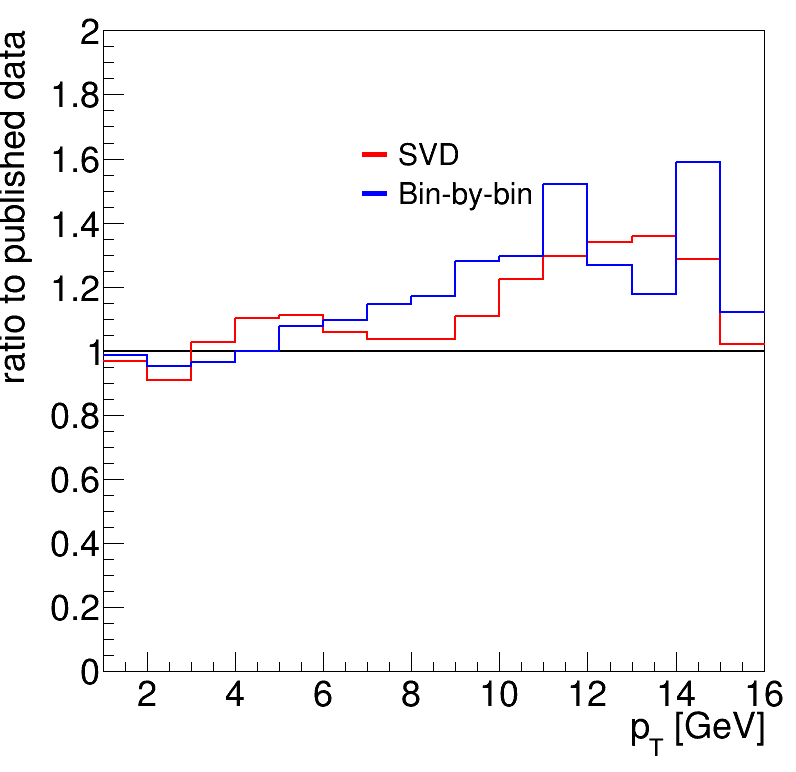

In [17]:
c= ROOT.TCanvas('c','c',800,800)


ratio_unity.Draw("histsame")
ratio_unity.SetTitle('; p_{T} [GeV]; ratio to published data')
ratio_unity.SetTitle('Data unfolded / Published data')
ratio_unity.SetMaximum(2.0)
ratio_unity.SetMinimum(0.0)
ratio_data_unfolded_SVD_4_corrected.Draw('histsame')
#ratio_data_unfolded_SVD_5_corrected.Draw('histsame')
ratio_data_corrected.Draw('histsame')
#ratio_data_raw.Draw("histsame")
#ratio_data_bkgsub.Draw("histsame")
#ratio_data_unfoldedSVD4.Draw("histsame")

label = Legend("")
label.Add(ratio_data_unfolded_SVD_4_corrected,'SVD','L')
#label.Add(ratio_data_unfolded_SVD_5_corrected,'SVD k=5 + eff corr.','L')
label.Add(ratio_data_corrected,'Bin-by-bin','L')
label.Draw(.45,.85)

c.Draw()
c.SaveAs('Comparison_Unfolded_tracking.png')


In [18]:
##Refolding

In [44]:
##refolding the distribution:
def applyEfficiencyUnCorrection(histo):
    histo_corrected = histo.Clone()
    for i in range(1,histo.GetNbinsX()+1):
        pt = ROOT.Double()
        eff = ROOT.Double()
        efficiency.GetPoint(i-1,pt,eff)
        #print pt, eff
        histo_corrected.SetBinContent(i,histo.GetBinContent(i)*eff)
        histo_corrected.SetBinError(i,histo.GetBinError(i)*eff)
    return histo_corrected

# h=published data 
h_wEff = applyEfficiencyUnCorrection(h)
h_wEff.SetLineColor(ROOT.kRed)
N = h_wEff.GetNbinsX()#data_unfolded['SVD8'].GetNbinsX()


data_refolded= h_wEff.Clone()#data_unfolded['SVD9'].Clone()
data_refolded.SetLineColorAlpha(4,0.5)

for ireco in range(1,N+1):
    temp = 0
    for itruth in range(1,N+1):
        #print responseMatrix.GetBinContent(itruth,ireco)
        #print data_unfolded['SVD'].GetBinContent(itruth)
        temp += responseMatrix.GetBinContent(itruth,ireco)*h_wEff.GetBinContent(itruth)
    data_refolded.SetBinContent(ireco, temp)
 
integralBins = 1

print h_wEff.Integral(integralBins,N)
print data_refolded.Integral(integralBins,N)
print h_wEff.Integral(integralBins,N)/data_refolded.Integral(integralBins,N)
data_refolded.Scale(h_wEff.Integral(integralBins,N)/data_refolded.Integral(integralBins,N))
print data_refolded.Integral(integralBins,N)


2.27624730489
1633.76597619
0.00139325174968
2.27624725262


Info in <TCanvas::Print>: png file refolding_wScaling.png has been created


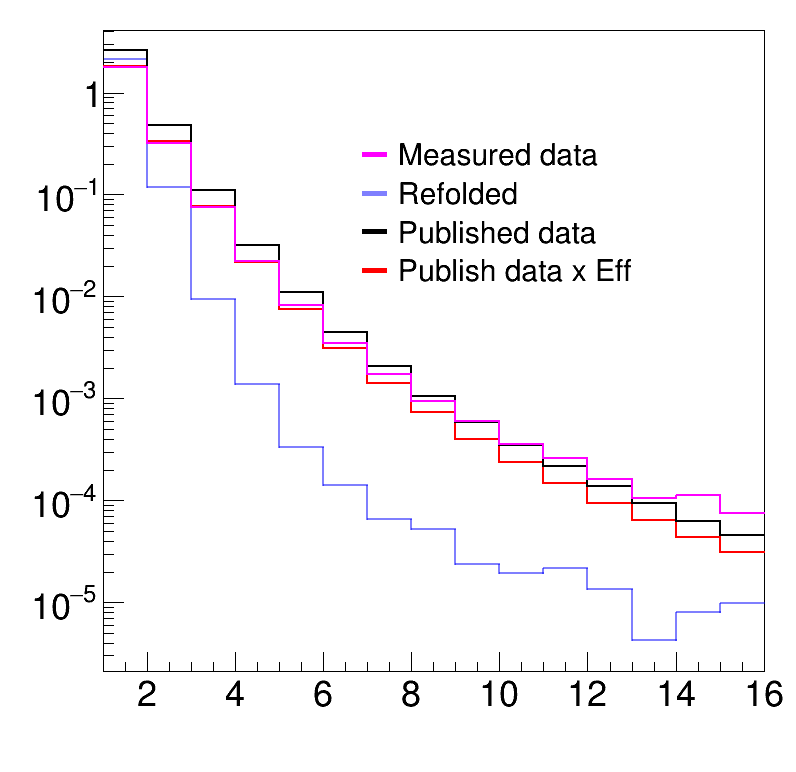

In [50]:
#plotting the refolded results
c.Clear()
data.SetLineColor(ROOT.kMagenta)

data_refolded.Draw()
h_wEff.Draw('histsame')
h.Draw('histsame')
data.Draw('histsame')

label = Legend("")
label.Add(data,'Measured data','L')
label.Add(data_refolded,'Refolded','L')
label.Add(h,'Published data','L')
label.Add(h_wEff,'Publish data x Eff','L')
label.Draw(.45,.85)

c.SetLogy()
c.Draw()
c.SaveAs('refolding_wScaling.png')

In [21]:
ratio_unfoldedSVD_pub = data_unfolded['SVD8'].Clone()
ratio_unfoldedSVD_pub.Divide(h)

ratio_data_pub = data_inputforunfolding.Clone()
ratio_data_pub.Divide(h)

ratio_refold_pub = data_refolded.Clone()
ratio_refold_pub.Divide(h)


True

Warning in <TH1D::Divide>: Dividing histograms with different bin limits
Warning in <TH1F::Divide>: Dividing histograms with different bin limits


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file ratio_refolding.png has been created


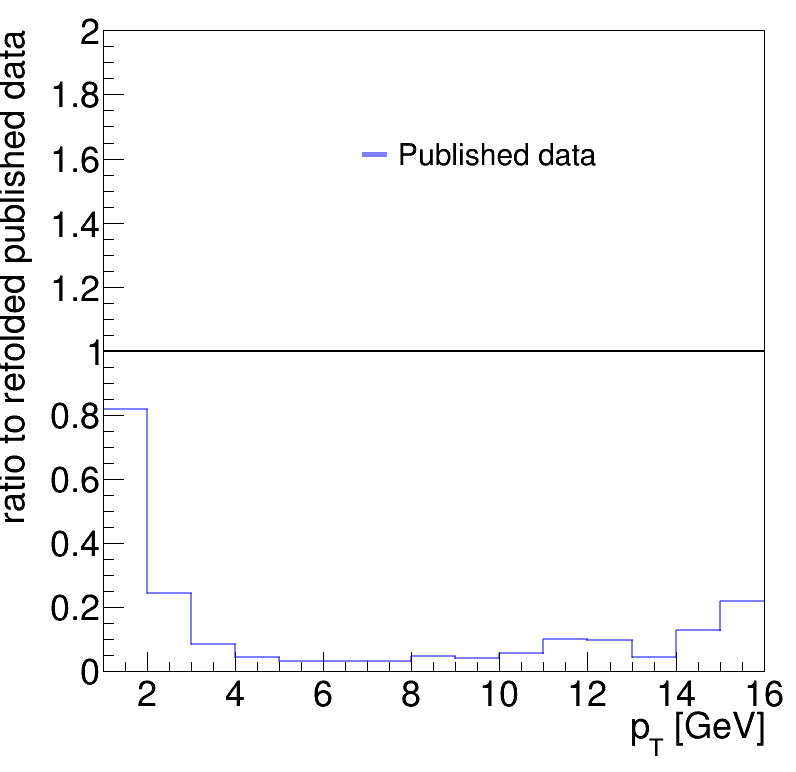

In [22]:
c= ROOT.TCanvas('c','c',800,800)

ratio_unity.Draw('hist')
ratio_unity.SetTitle('; p_{T} [GeV]; ratio to refolded published data')
ratio_unity.SetTitle('Data unfolded / Published data')
ratio_unity.SetMaximum(2.0)
ratio_unity.SetMinimum(0.0)
#ratio_refold_unfoldedSVD.Draw('histsame')
#ratio_refold_data.Draw('histsame')
ratio_refold_pub.Draw('histsame')

label = Legend("")
#label.Add(ratio_unfoldedSVD_pub,'unfolded','L')
#label.Add(ratio_data_unfolded_SVD_5_corrected,'SVD k=5 + eff corr.','L')
#label.Add(ratio_data_pub,'data','L')
label.Add(ratio_refold_pub,'Published data','L')
label.Draw(.45,.85)


c.Draw()
c.SaveAs('ratio_refolding.png')